In [203]:
file = 'data/bipartite/sample/train.in'
N = 0

In [204]:
import tools

In [205]:
train_set, nodes, poss_set, neg_set = tools.sample_bipartite(file, N)

# Choose poss set with less components increasing

In [122]:
from graph_tool.all import *
g = Graph(directed=False)
g.add_vertex(max(nodes) + 1)
for edge in train_set:
    u, w = map(int, edge.split())
    g.add_edge(g.vertex(u), g.vertex(w))

In [86]:
train_set_2 = set()
for edge in train_set:
    u, w = map(int, edge.split())
    if g.vertex(u).out_degree() > 1 and g.vertex(w).out_degree() > 1:
        train_set_2.add(edge)

In [87]:
len(train_set_2)

724

In [88]:
poss_set = tools.sample_structural_poss(train_set_2, int(N * len(train_set) / 100.))

# Get coordinates

In [221]:
from graph_tool.all import *
g = Graph(directed=False)
g.add_vertex(max(nodes) + 1)

<generator object <genexpr> at 0x7f6485f56870>

In [222]:
a = 0
for edge in train_set:
    if edge not in poss_set:
        a += 1
        u, w = map(int, edge.split())
        g.add_edge(g.vertex(u), g.vertex(w))
print 1.0 * a / len(train_set)

1.0


In [223]:
is_bi, part = graph_tool.topology.is_bipartite(g, partition=True)

In [224]:
is_bi

True

In [225]:
groups = g.new_vertex_property("int")

In [226]:
for u in g.vertices():
    groups[u] = part[u]

In [238]:
pos = sfdp_layout(g, groups=groups, bipartite=False, verbose=True, gamma=0.0, mu=0)

libgraph_tool_layout.sfdp verbose:  True bipartite:  False


In [239]:
pos_bip = sfdp_layout(g,  groups=groups, bipartite=True, verbose=True, gamma=0.0, mu=0)

libgraph_tool_layout.sfdp verbose:  True bipartite:  True


libgraph_tool_layout.sfdp verbose:  False bipartite:  False


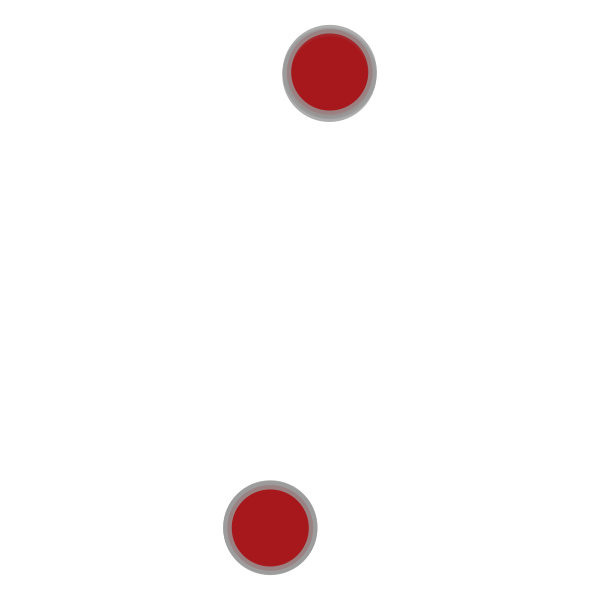

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7f648c0da0d0, at 0x7f6485f58ad0>

In [240]:
%matplotlib inline

graph_draw(g)

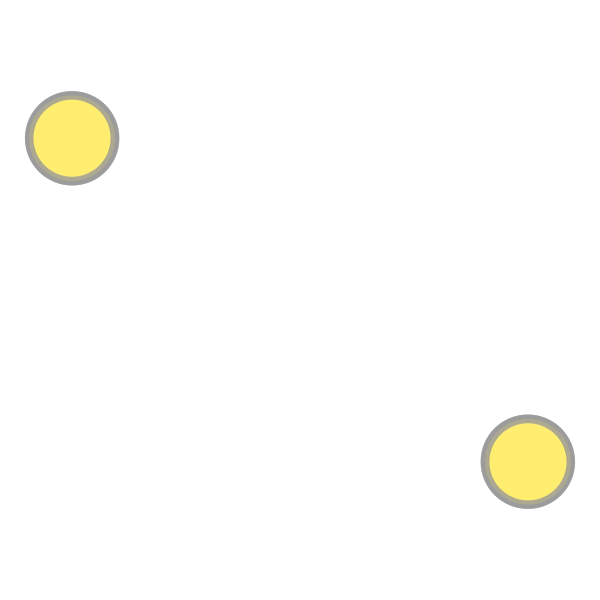

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7f648c0da0d0, at 0x7f648c0da110>

In [241]:
%matplotlib inline

graph_draw(g, pos=pos, vertex_fill_color=groups)

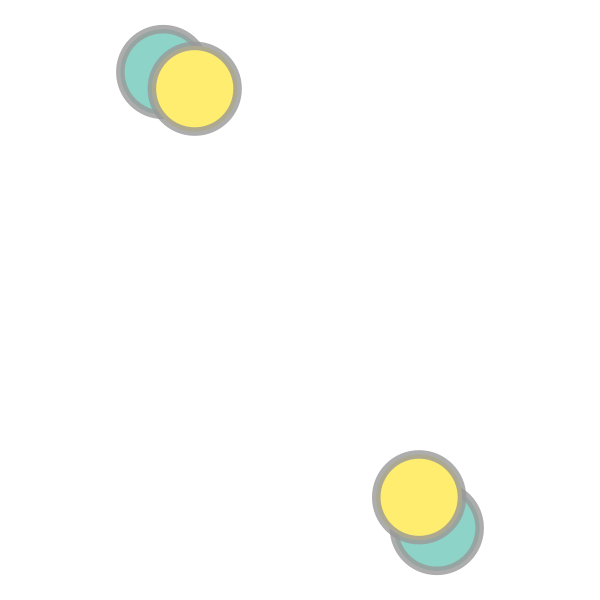

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7f648c0da0d0, at 0x7f648c0c4c90>

In [242]:
%matplotlib inline

graph_draw(g, pos=pos_bip, vertex_fill_color=groups)

In [115]:
from sklearn.metrics import roc_auc_score

In [116]:
features = tools.TopologicalFeatures(g, pos_bip, gap=1)
X, Y = tools.make_dataset(poss_set, neg_set, 
                    [features.dist])
roc_auc_score(Y, X)

0.43572902983674239

In [117]:
features = tools.TopologicalFeatures(g, pos)
X, Y = tools.make_dataset(poss_set, neg_set, 
                    [features.dist])
roc_auc_score(Y, X)

0.44830174516794896

In [118]:
features = tools.TopologicalFeatures(g, pos)
X, Y = tools.make_dataset(poss_set, neg_set, 
                    [features.preferential_attachment])
roc_auc_score(Y, X)

0.70970163257646846